# 순환 신경망의 고급 사용법
이제 RNN 성능을 향상 시키기 위한 세 가지 고급 기술으 살펴보겠습니다. 온도 예측 문제로 세 가지 개념을 모두 시연해 보겠습니다. 이 시계열 데이터는 건물 옥상에 설치된 센서에서 취득한 온도, 기압, 습도 같은 데이터입니다. 이 데이터를 사용하여 마지막 데이터 포인트에서부터 24시간 이후의 온도를 예측하겠습니다. 이 문제는 시계열 데이터에서 일반적으로 나타나는 여러 가지 어려운 점을 가지고 있습니다. 전형적이고 꽤 도전적인 문제입니다.

다음 기법들을 적용하겠습니다.
- 순환 드롭아웃 : 순환 층에서 과대 적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용합니다.
- 순환 층 스태킹 : 네트워크의 표현 능력을 증가시킵니다(비용이 많이 듭니다).
- 양방향 순환 층 : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.

# 기온 예측 문제
지금까지 다룬 시퀀스 데이터는 텍스트 데이터였지만 이번에는 날씨 시계열 데이터를 사용하겠습니다. 여기서는 2009년~2016년 데이터를 사용하겠습니다. 24시간 이후 기온을 예측하는 모델을 만들어봅니다.

In [2]:
import os

source = r"C:\Users\user\Desktop\MLDL 학습용 데이터셋\jena_climate_2009_2016.csv"

f = open(source)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


420,551개 데이터 전체를 넘파이 배열로 바꿉니다

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

예를 들어 다음은 시간에 따른 기온 그래프입니다.

In [4]:
from matplotlib import pyplot as plt

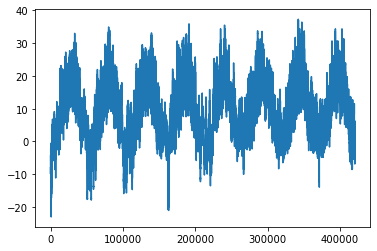

In [5]:
temp = float_data[:, 1] # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

온도에 주기성이 있음을 확인할 수 있습니다. 다음은 기간을 좁혀서 처음 10일 간의 데이터를 보겠습니다. 10분마다 관측되었으므로 하루에 총 144개 데이터 포인트입니다.

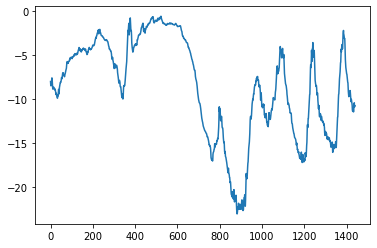

In [6]:
plt.plot(range(1440), temp[:1440])
plt.show()

# Preparing the data
이 문제의 정확한 정의는 다음과 같습니다. lookback 타임스텝(하나의 타임스텝은 10분)만큼 이전으로 돌아가서 매 steps마다 샘플링합니다. 이 데이터르 바탕으로 delay 타임스텝 이후의 온도를 예측할 수 있을까요? 다음 변수를 사용합니다.

- lookback = 1440 : 10일 전 데이터로 돌아갑니다
- steps = 6 : 한 시간마다 데이터 포인트 하나를 샘플링합니다.
- delay = 144 : 24시간이 지난 데이터가 타깃이 됩니다.

시작하기 전에 두 가지 작업을 처리해야합니다.

- 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않습니다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다(예를 들어 온도는 일반적으로 -20~+30도 사이이고, mb(밀리바)로 측정된 기압은 1,000 근처의 값입니다). 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠습니다.
- float_data 배열을 받아 과거 데이터의 배치과 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다. 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 원본 데이터를 사용해 그때 그때 배치를 만들겠습니다. 

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다. 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산합니다.

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

다음은 여기서 사용할 제너레이터입니다. 이 제너레이터 함수는 (samples, targets) 튜플을 반복적으로 반환합니다. samples는 입력 데이터로 사용할 배치이고 targets은 이에 대응되는 타깃 온도의 배열입니다. 이 제너레이터 함수는 다음과 같은 매개변수를 받게 할 것입니다.

- data : 부동 소수 데이터로 이루어진 원본 배열
- lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
- delay : 타깃으로 사용할 미래의 타임 스텝
- min_index, max_index : 추출할 타임스텝의 범위를 지정하기 위한 data의 인덱스
- shuffle : 샘플을 섞을지 시간 순서대로 추출할지를 결정
- batch_size : 배치의 샘플 수
- step : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나를 추출하므로 6으로 지정합니다.

In [8]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i - min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

generator 함수를 사용하여 훈련, 검증, 테스트용 세 개의 제너레이터를 만들어 보겠습니다. 훈련 제너레이터는 200,000개 타임스텝을 사용하고, 검증 제너레이터는 100,000개를, 테스트 제너레이터는 나머지를 사용합니다.

In [9]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size = batch_size)


In [10]:
# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 상식 수준의 기준점
블랙 박스 같은 딥러닝 모델을 사용해 온도 예측 문제를 풀기 전에 간단한 상식 수준의 해법을 시도해 보겠습니다. 이는 정상 여부 확인을 위한 용도이고 고수준 머신 러닝 모델이라면 뛰어 넘어야 할 기준점을 만듭니다. 이런 상식 수준의 해법은 알려진 해결책이 없는 새로운 문제를 다루어야 할 때 유용합니다. 일부 클래스가 월등히 많아 불균형한 분류 문제가 고전적인 예입니다. 데이터셋에 클래스 A의 샘플이 90%, 클래스 B의 샘플이 10%가 있다면, 이 분류 문제에 대한 상식 수준의 접근법은 새로운 샘플을 항상 클래스 'A'라고 예측하는 것입니다. 이 분류기는 전반적으로 90%의 정확도를 낼 것입니다. 머신 러닝 기반의 모델이라면 90% 이상을 달성해야 유용하다고 볼 수 있습니다. 이따금 이런 기본적인 기준점을 넘어서기가 아주 어려운 경우가 있습니다.

이 경우 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있습니다(오늘 온도는 내일 온도와 비슷할 가능성이 높습니다). 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측하는 것입니다. 이 방법을 평균 절댓값 오차(MAE)로 평가해 보겠습니다: